##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Keras 中的循环神经网络 (RNN)

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/guide/keras/rnn"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/rnn.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/rnn.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/keras/rnn.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

## 简介

循环神经网络 (RNN) 是一类神经网络，它们在序列数据（如时间序列或自然语言）建模方面非常强大。

简单来说，RNN 层会使用 `for` 循环对序列的时间步骤进行迭代，同时维持一个内部状态，对截至目前所看到的时间步骤信息进行编码。

Keras RNN API 的设计重点如下：

- **易于使用**：您可以使用内置 `keras.layers.RNN`、`keras.layers.LSTM` 和 `keras.layers.GRU` 层快速构建循环模型，而无需进行艰难的配置选择。

- **易于自定义**：您还可以通过自定义行为来定义您自己的 RNN 单元层（`for` 循环的内部），并将其用于通用的 `keras.layers.RNN` 层（`for` 循环本身）。这使您能够以最少的代码和灵活的方式快速为不同研究思路设计原型。

## 设置

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 内置 RNN 层：简单示例

Keras 中有三种内置 RNN 层：

1. `keras.layers.SimpleRNN`，一个全连接 RNN，其中前一个时间步骤的输出会被馈送至下一个时间步骤。

2. `keras.layers.GRU`，最初由 [Cho 等人于 2014 年](https://arxiv.org/abs/1406.1078)提出。

3. `keras.layers.LSTM`，最初由 [Hochreiter 和 Schmidhuber 于 1997 年](https://www.bioinf.jku.at/publications/older/2604.pdf)提出。

2015 年初，Keras 首次具有了 LSTM 和 GRU 的可重用开源 Python 实现。

下面是一个 `Sequential` 模型的简单示例，该模型可以处理整数序列，将每个整数嵌入 64 维向量中，然后使用 `LSTM` 层处理向量序列。

In [2]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

2022-04-26 15:36:10.594137: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


内置 RNN 支持许多实用功能：

- 通过 `dropout` 和 `recurrent_dropout` 参数进行循环随机失活
- 能够通过 `go_backwards` 参数反向处理输入序列
- 通过 `unroll` 参数进行循环展开（这会大幅提升在 CPU 上处理短序列的速度）
- …以及更多功能。

有关详情，请参阅 [RNN API 文档](https://keras.io/api/layers/recurrent_layers/)。

## 输出和状态

默认情况下，RNN 层的输出为每个样本包含一个向量。此向量是与最后一个时间步骤相对应的 RNN 单元输出，包含关于整个输入序列的信息。此输出的形状为 `(batch_size, units)`，其中 `units` 对应于传递给层构造函数的 `units` 参数。

如果您设置了 `return_sequences=True`，RNN 层还能返回每个样本的整个输出序列（每个样本的每个时间步骤一个向量）。此输出的形状为 `(batch_size, timesteps, units)`。

In [3]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, None, 256)         247296    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


此外，RNN 层还可以返回其最终内部状态。返回的状态可用于稍后恢复 RNN 执行，或[初始化另一个 RNN](https://arxiv.org/abs/1409.3215)。此设置常用于编码器-解码器序列到序列模型，其中编码器的最终状态被用作解码器的初始状态。

要配置 RNN 层以返回其内部状态，请在创建该层时将 `return_state` 参数设置为 `True`。请注意，`LSTM` 具有两个状态张量，但 `GRU` 只有一个。

要配置该层的初始状态，只需额外使用关键字参数 `initial_state` 调用该层。请注意，状态的形状需要匹配该层的单元大小，如下例所示。

In [4]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 64)     64000       ['input_1[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 64)     128000      ['input_2[0][0]']                
                                                                                              

## RNN 层和 RNN 单元

除内置 RNN 层外，RNN API 还提供单元级 API。与处理整批输入序列的 RNN 层不同，RNN 单元仅处理单个时间步骤。

单元位于 RNN 层的 `for` 循环内。将单元封装在 `keras.layers.RNN` 层内，您会得到一个能够处理序列批次的层，如 `RNN(LSTMCell(10))`。

从数学上看，`RNN(LSTMCell(10))` 会产生和 `LSTM(10)` 相同的结果。但实际上，此层在 TF v1.x 中的实现只会创建对应的 RNN 单元并将其封装在 RNN 层内。但是，如果使用内置的 `GRU` 和 `LSTM` 层，您就能够使用 CuDNN，并获得更出色的性能。

共有三种内置 RNN 单元，每种单元对应于匹配的 RNN 层。

- `keras.layers.SimpleRNNCell` 对应于 `SimpleRNN` 层。

- `keras.layers.GRUCell` 对应于 `GRU` 层。

- `keras.layers.LSTMCell` 对应于 `LSTM` 层。

借助单元抽象和通用 `keras.layers.RNN` 类，您可以为研究轻松实现自定义 RNN 架构。

## 跨批次有状态性

在处理非常长的序列（可能无限长）时，您可能需要使用**跨批次有状态性**模式。

通常情况下，每次看到新批次时，都会重置 RNN 层的内部状态（即，假定该层看到的每个样本都独立于过去）。该层将仅在处理给定样本时保持状态。

但如果您的序列非常长，一种有效做法是将它们拆分成较短的序列，然后将这些较短序列按顺序馈送给 RNN 层，而无需重置该层的状态。如此一来，该层就可以保留有关整个序列的信息，尽管它一次只能看到一个子序列。

您可以通过在构造函数中设置 `stateful=True` 来执行上述操作。

如果您有一个序列 `s = [t0, t1, ... t1546, t1547]`，可以将其拆分成如下式样：

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

然后，您可以通过以下方式处理它：

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

想要清除状态时，您可以使用 `layer.reset_states()`。

> 注：在此设置中，假设给定批次中的样本 `i` 是上一个批次中样本 `i` 的延续。也就是说，所有批次应该包含相同的样本数量（批次大小）。例如，如果一个批次包含 `[sequence_A_from_t0_to_t100,  sequence_B_from_t0_to_t100]`，则下一个批次应该包含 `[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`。

以下是完整示例：

In [5]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


### RNN 状态重用

<a id="rnn_state_reuse"></a>

RNN 层的记录状态不包含在 `layer.weights()` 中。如果您想重用 RNN 层的状态，可以通过 `layer.states` 找回状态值，并通过 Keras 函数式 API（如 `new_layer(inputs, initial_state=layer.states)`）或模型子类化将其用作新层的初始状态。

另请注意，此情况可能不适用于序贯模型，因为它只支持具有单个输入和输出的层，而初始状态具有额外输入，因此无法在此使用。

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## 双向 RNN

对于时间序列以外的序列（如文本），如果 RNN 模型不仅能从头到尾处理序列，而且还能反向处理的话，它的性能通常会更好。例如，要预测句子中的下一个单词，通常比较有用的是掌握单词的上下文，而非仅仅掌握该单词前面的单词。

Keras 为您提供了一个简单的 API 来构建此类双向 RNN：`keras.layers.Bidirectional` 封装容器。

In [8]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


`Bidirectional` 会在后台复制传入的 RNN 层，并翻转新复制的层的 `go_backwards` 字段，这样它就能按相反的顺序处理输入了。

默认情况下，`Bidirectional` RNN 的输出将是前向层输出和后向层输出的串联。如果您需要串联等其他合并行为，请更改 `Bidirectional` 封装容器构造函数中的 `merge_mode` 参数。如需详细了解 `Bidirectional`，请查看 [API 文档](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Bidirectional/)。

## 性能优化和 CuDNN 内核

在 TensorFlow 2.0 中，内置的 LSTM 和 GRU 层已经更新，会在 GPU 可用时默认使用 CuDNN 内核。本次更改后，之前的 `keras.layers.CuDNNLSTM/CuDNNGRU` 层已被弃用，您在构建模型时不再需要担心运行它的硬件了。

由于 CuDNN 内核是基于某些假设构建的，这意味着**如果您更改了内置 LSTM 或 GRU 层的默认设置，则该层将无法使用 CuDNN 内核**。例如：

- 将 `activation` 函数从 `tanh` 更改为其他。
- 将 `recurrent_activation` 函数从 `sigmoid` 更改为其他。
- 使用大于零的 `recurrent_dropout`。
- 将 `unroll` 设置为 True，这会强制 LSTM/GRU 将内部 `tf.while_loop` 分解成未展开的 `for` 循环。
- 将 `use_bias` 设置为 False。
- 当输入数据没有严格正确地填充时使用遮盖（如果掩码对应于严格正确的填充数据，则仍可使用 CuDNN。这是最常见的情况）。

有关约束的详细列表，请参阅 [GRU](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/LSTM/) 和 [GRU](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/GRU/) 层的文档。

### 在可用时使用 CuDNN 内核

让我们构建一个简单的 LSTM 模型来演示性能差异。

我们将使用 MNIST 数字的行序列作为输入序列（将每一行像素视为一个时间步骤），并预测数字的标签。

In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


加载 MNIST 数据集：

In [10]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

创建一个模型实例并对其进行训练。

我们选择 `sparse_categorical_crossentropy` 作为模型的损失函数。模型的输出形状为 `[batch_size, 10]`。模型的目标是一个整数向量，每个整数都在 0 到 9 之间。

In [11]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

2021-08-13 20:01:45.666097: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


938/938 [==============================] - 6s 5ms/step - loss: 0.9718 - accuracy: 0.6885 - val_loss: 0.6704 - val_accuracy: 0.7794


现在，我们与未使用 CuDNN 内核的模型进行对比：

In [12]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 32s 33ms/step - loss: 0.4087 - accuracy: 0.8758 - val_loss: 0.3126 - val_accuracy: 0.8989


在安装了 NVIDIA GPU 和 CuDNN 的计算机上运行时，使用 CuDNN 构建的模型的训练速度要比使用常规 TensorFlow 内核的模型快得多。

启用了 CuDNN 的相同模型也可用来在纯 CPU 环境中运行推断。下面的 `tf.device` 注解只是强制设备放置。如果没有可用的 GPU，则该模型将默认在 CPU 上运行。

您再也不必担心运行的硬件了。这是不是很棒？

Predicted result is: [3], target result is: 5


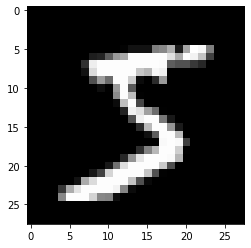

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## 支持列表/字典输入或嵌套输入的 RNN

实现器可以通过嵌套结构在单个时间步骤内包含更多信息。例如，一个视频帧可以同时包含音频和视频输入。在这种情况下，数据形状可以为：

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

在另一个示例中，手写数据可以包括笔的当前位置的 x 和 y 坐标，以及压力信息。因此，数据表示可以为：

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

以下代码提供了一个示例，演示了如何构建接受此类结构化输入的自定义 RNN 单元。

### 定义一个支持嵌套输入/输出的自定义单元

有关自行编写层的详细信息，请参阅[通过子类化创建新层和模型](https://tensorflow.google.cn/guide/keras/custom_layers_and_models/)。

In [14]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### 使用嵌套输入/输出构建 RNN 模型

让我们构建一个使用 `keras.layers.RNN` 层和刚刚定义的自定义单元的 Keras 模型。

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### 使用随机生成的数据训练模型

由于此模型没有合适的候选数据集，我们使用随机 Numpy 数据进行演示。

In [16]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 1s 26ms/step - loss: 0.7535 - rnn_1_loss: 0.2860 - rnn_1_1_loss: 0.4675 - rnn_1_accuracy: 0.1016 - rnn_1_1_accuracy: 0.0345


使用 Keras `keras.layers.RNN` 层，您只需定义序列内单个步骤的数学逻辑，`keras.layers.RNN` 层将为您处理序列迭代。您可以通过这种异常强大的方式快速为新型 RNN（如 LSTM 变体）设计原型。

有关详情，请访问 [API 文档](https://https://tensorflow.google.cn/api_docs/python/tf/keras/layers/RNN/)。